In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [01:03<00:00, 88.6MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:
import pandas as pd
import os

# Finding the metadata file
metadata_file = None
for root, dirs, files in os.walk(path):
    if 'HAM10000_metadata.csv' in files:
        metadata_file = os.path.join(root, 'HAM10000_metadata.csv')
        break

if metadata_file:
    metadata_df = pd.read_csv(metadata_file)
    print(metadata_df.head())
    print(metadata_df.info())
else:
    print("Metadata file not found. Please check the dataset structure.")

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


# Image Preprocessing

First all images were loaded

In [ ]:
# Define paths to the image folders
image_folder_1 = os.path.join(path, 'HAM10000_images_part_1')
image_folder_2 = os.path.join(path, 'HAM10000_images_part_2')

# Verify the contents of each folder to ensure the paths are correct
print("Contents of HAM10000_images_part_1:")
print(os.listdir(image_folder_1)[:5])  # Display the first 5 files

print("Contents of HAM10000_images_part_2:")
print(os.listdir(image_folder_2)[:5])  # Display the first 5 files


Contents of HAM10000_images_part_1:
['ISIC_0028543.jpg', 'ISIC_0024410.jpg', 'ISIC_0024760.jpg', 'ISIC_0028326.jpg', 'ISIC_0028212.jpg']
Contents of HAM10000_images_part_2:
['ISIC_0033668.jpg', 'ISIC_0032248.jpg', 'ISIC_0030753.jpg', 'ISIC_0031668.jpg', 'ISIC_0032602.jpg']


In [ ]:
# List all image files in both folders
image_files_1 = [os.path.join(image_folder_1, f) for f in os.listdir(image_folder_1) if f.endswith('.jpg')]
image_files_2 = [os.path.join(image_folder_2, f) for f in os.listdir(image_folder_2) if f.endswith('.jpg')]

# Combine the lists into a single list of image paths
all_image_paths = image_files_1 + image_files_2

print(f"Number of images found: {len(all_image_paths)}")


Number of images found: 10015


We selected a proportional sample of 5000 images from the original dataset to balance computational efficiency with maintaining the dataset's original class distribution, ensuring a representative yet manageable dataset for model training and evaluation.

In [ ]:
import random

def get_balanced_sample_proportional(metadata_df, image_paths, total_size=5000):
    """
    Create a balanced sample proportional to the original class distribution.
    """
    # Calculate original class proportions
    class_counts = metadata_df['dx'].value_counts()
    total_images = len(metadata_df)
    class_proportions = class_counts / total_images

    # Calculate number of samples needed for each class
    samples_per_class = (class_proportions * total_size).round().astype(int)

    print("\nSamples to select per class:")
    print(samples_per_class)

    # Organize paths by class
    class_paths = {dx: [] for dx in class_counts.index}
    for path in image_paths:
        img_id = os.path.splitext(os.path.basename(path))[0]
        diagnosis = metadata_df[metadata_df['image_id'] == img_id]['dx'].iloc[0]
        class_paths[diagnosis].append(path)

    # Sample proportionally from each class
    sampled_paths = []
    sampled_labels = []

    for diagnosis, num_samples in samples_per_class.items():
        paths = class_paths[diagnosis]
        sampled_paths.extend(random.sample(paths, num_samples))
        sampled_labels.extend([diagnosis] * num_samples)

    return sampled_paths, sampled_labels

# Create a balanced sample of 5000 images
balanced_sampled_image_paths, balanced_sampled_labels = get_balanced_sample_proportional(metadata_df, all_image_paths, total_size=5000)

print(f"Total sampled images: {len(balanced_sampled_image_paths)}")



Samples to select per class:
dx
nv       3347
mel       556
bkl       549
bcc       257
akiec     163
vasc       71
df         57
Name: count, dtype: int64
Total sampled images: 5000


# Image Transformation Pipeline


1. Smart crop images to focus on lesions
2. Resized images to 224x224
3. Apply data augmentation:

  *   Random horizontal flips
  *   Random rotations
  *   Color jittering
  *   Random vertical flips

5. Convert to tensors
6. Normalize the images
7. Stacks all processed images into one tensor
8. Provides visualization to check results




In [ ]:
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm

# Smart crop function
def smart_crop(image):
    """Crop the image to focus on the lesion."""
    # Convert to numpy array
    img_array = np.array(image)

    # Convert to grayscale for thresholding
    if len(img_array.shape) == 3:  # If RGB image
        gray = np.mean(img_array, axis=2)
    else:
        gray = img_array  # If already grayscale

    # Find the lesion using thresholding
    thresh = np.mean(gray)
    binary = gray < thresh

    # Find lesion boundaries
    rows = np.any(binary, axis=1)
    cols = np.any(binary, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # Add padding
    padding = 10
    ymin = max(ymin - padding, 0)
    ymax = min(ymax + padding, gray.shape[0])
    xmin = max(xmin - padding, 0)
    xmax = min(xmax + padding, gray.shape[1])

    # Crop the image
    cropped = image.crop((xmin, ymin, xmax, ymax))
    return cropped


In [ ]:
# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize to fixed size of 224 x 224
    transforms.RandomHorizontalFlip(),    # Randomly flip image horizontally
    transforms.RandomVerticalFlip(),      # Randomly flip image vertically
    transforms.RandomRotation(20),        # Randomly rotate image up to 20 degrees
    transforms.ColorJitter(               # Randomly adjust brightness and contrast
        brightness=0.1,
        contrast=0.1
    ),
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(                 # Normalize
        mean=[0.485, 0.456, 0.406],       # ImageNet mean
        std=[0.229, 0.224, 0.225]         # ImageNet std
    )
])

In [ ]:
# Process the dataset in batches of 1000
batch_size = 1000
processed_images = []
processed_labels = []

for i in range(0, len(balanced_sampled_image_paths), batch_size):
    batch_paths = balanced_sampled_image_paths[i:i + batch_size]  # Select a batch of paths
    print(f"Processing batch {i // batch_size + 1}/{(len(balanced_sampled_image_paths) + batch_size - 1) // batch_size}")

    for path in tqdm(batch_paths, desc=f"Batch {i // batch_size + 1}"):
        try:
            # Load and transform image
            img = Image.open(path).convert("RGB")  # Ensure RGB mode
            cropped_img = smart_crop(img)          # Apply smart crop
            transformed_img = transform(cropped_img)  # Apply transformations

            # Append processed image and corresponding label
            processed_images.append(transformed_img)

            # Extract label
            img_id = os.path.splitext(os.path.basename(path))[0]
            label = metadata_df[metadata_df['image_id'] == img_id]['dx'].iloc[0]
            processed_labels.append(label)
        except Exception as e:
            print(f"Error processing image {path}: {e}")

print(f"Total processed images: {len(processed_images)}")
print(f"Total processed labels: {len(processed_labels)}")


Processing batch 1/5


Batch 1: 100%|██████████| 1000/1000 [00:33<00:00, 30.09it/s]


Processing batch 2/5


Batch 2: 100%|██████████| 1000/1000 [00:33<00:00, 30.22it/s]


Processing batch 3/5


Batch 3: 100%|██████████| 1000/1000 [00:32<00:00, 30.83it/s]


Processing batch 4/5


Batch 4: 100%|██████████| 1000/1000 [00:31<00:00, 32.01it/s]


Processing batch 5/5


Batch 5: 100%|██████████| 1000/1000 [00:35<00:00, 28.47it/s]

Total processed images: 5000
Total processed labels: 5000


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Fit the encoder on the unique class labels in your dataset
label_encoder = LabelEncoder()
label_encoder.fit(metadata_df['dx'].unique())

# Stack all processed images into one tensor
X_processed = torch.stack(processed_images)
y_processed = torch.tensor([label_encoder.transform([label])[0] for label in processed_labels])

print("Processed images shape:", X_processed.shape)
print("Processed labels shape:", y_processed.shape)


Processed images shape: torch.Size([5000, 3, 224, 224])
Processed labels shape: torch.Size([5000])


We visualized a sample of the original vs processed images.

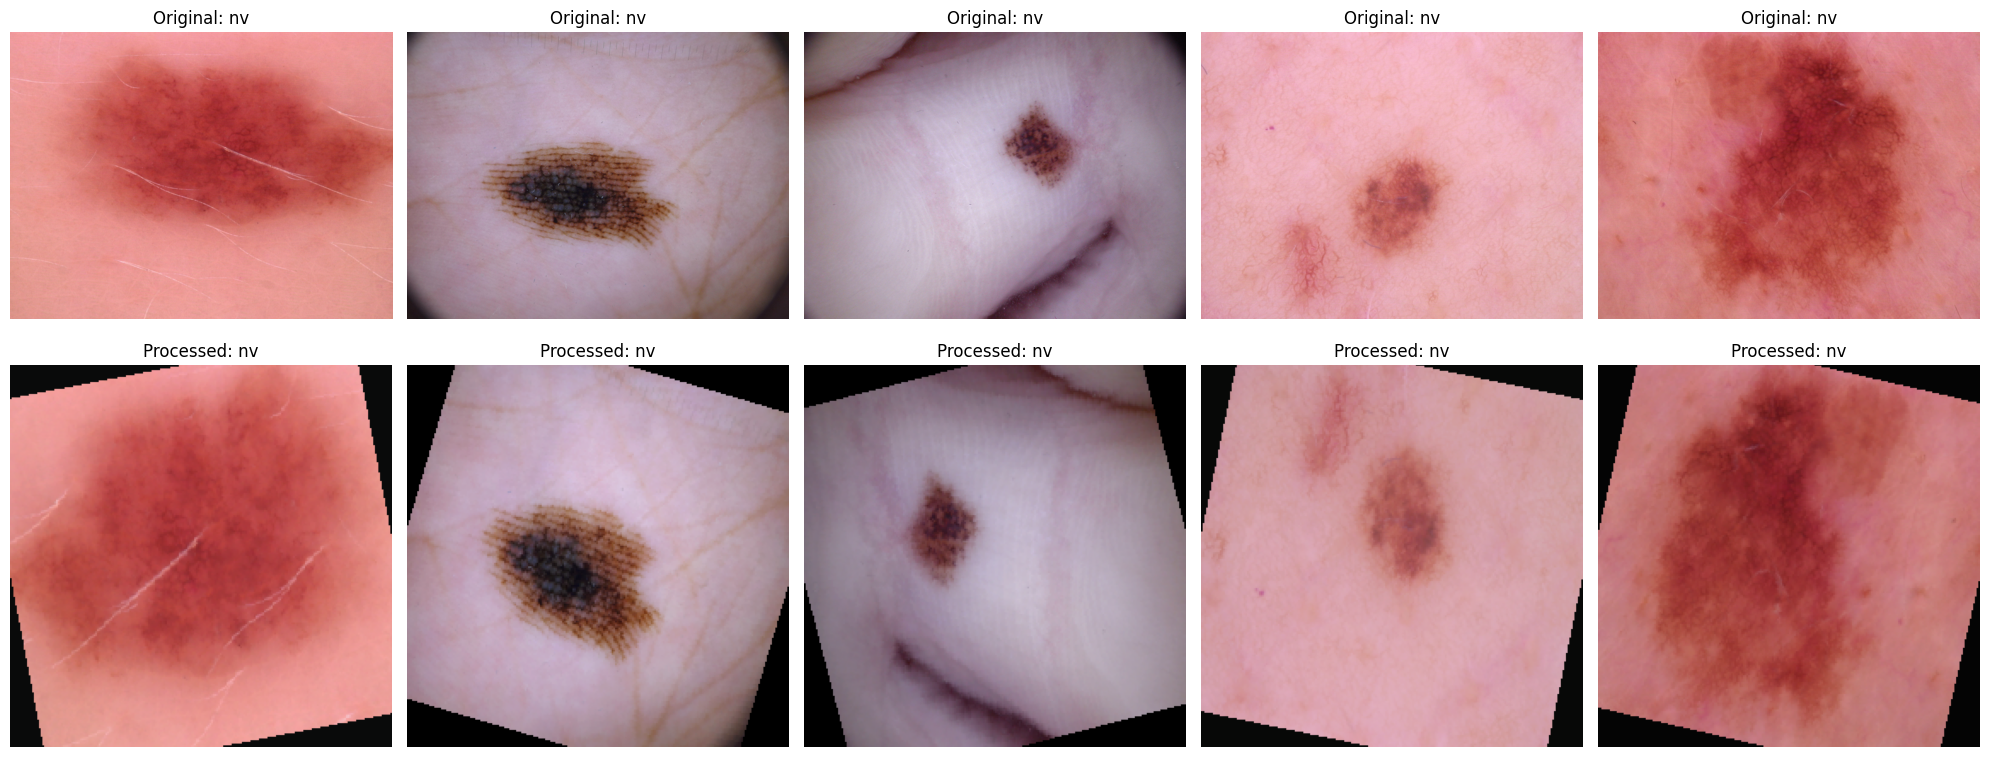

In [ ]:
import matplotlib.pyplot as plt

# Select a sample of 5 images
sample_paths = balanced_sampled_image_paths[:5]  # Take the first 5 images from your dataset

# Lists to hold original and processed images
original_images = []
processed_images_sample = []
diagnoses = []

# Process each image and store original and processed versions
for path in sample_paths:
    try:
        # Load the original image
        img = Image.open(path).convert("RGB")
        original_images.append(img)

        # Apply smart crop
        cropped_img = smart_crop(img)

        # Apply transformations
        transformed_img = transform(cropped_img)

        # Convert processed tensor back to image for visualization
        processed_img_np = transformed_img.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        processed_img_np = (processed_img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
        processed_img_np = (processed_img_np * 255).astype('uint8')  # Convert to 8-bit image
        processed_images_sample.append(processed_img_np)

        # Extract diagnosis
        img_id = os.path.splitext(os.path.basename(path))[0]
        diagnosis = metadata_df[metadata_df['image_id'] == img_id]['dx'].iloc[0]
        diagnoses.append(diagnosis)
    except Exception as e:
        print(f"Error processing image {path}: {e}")

# Plot original vs processed images in a 2x5 layout
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(5):
    # Show original image
    axes[0, i].imshow(original_images[i])
    axes[0, i].set_title(f"Original: {diagnoses[i]}")
    axes[0, i].axis("off")

    # Show processed image
    axes[1, i].imshow(processed_images_sample[i])
    axes[1, i].set_title(f"Processed: {diagnoses[i]}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


# Processed Images Saved As:

The file processed_images.pt contains:
X_processed: The tensor of processed images (shape: (5000, 3, H, W)).
y_processed: The tensor of encoded labels (shape: (5000,)).

# To load processed images and labels
X_loaded, y_loaded = torch.load("processed_images.pt")

print("Processed data loaded successfully")
print(f"Loaded images shape: {X_loaded.shape}")
print(f"Loaded labels shape: {y_loaded.shape}")

In [ ]:
import torch

# Save processed images and labels in one file
torch.save((X_processed, y_processed), "processed_images.pt")
print("Processed data saved as 'processed_images.pt'")


Processed data saved as 'processed_images.pt'


# CNN Code (Needs to split into sub sections maybe)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SkinLesionCNN(nn.Module):
    def __init__(self, num_classes=7):  # 7 classes in HAM10000
        super(SkinLesionCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Fourth convolutional block
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Adaptive pooling to handle varying input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        val_loss = val_loss / len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return model

def main():
    # Model parameters
    num_classes = 7
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001

    # Load your processed data
    X_processed, y_processed = torch.load("processed_images.pt")

    # Split into train and validation sets
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(
        X_processed, y_processed, test_size=0.2, random_state=42, stratify=y_processed
    )

    # Create data loaders
    from torch.utils.data import TensorDataset, DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SkinLesionCNN(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

if __name__ == "__main__":
    main()

<ipython-input-1-f32b361c7143>:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_processed, y_processed = torch.load("processed_images.pt")


Epoch [1/50]
Train Loss: 1.0766 | Train Acc: 66.20%
Val Loss: 1.0207 | Val Acc: 67.00%
Epoch [2/50]
Train Loss: 1.0059 | Train Acc: 66.90%
Val Loss: 0.9734 | Val Acc: 67.00%
Epoch [3/50]
Train Loss: 1.0301 | Train Acc: 66.80%
Val Loss: 0.9968 | Val Acc: 67.00%
